<a href="https://colab.research.google.com/github/NolanHenderson/TNAG/blob/main/Stock_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Necessary Imports**

In [ ]:
import yfinance as yf
import pandas as pd
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import neural_network
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

**Important variables that, when changed, will alter this predictor's functionality**

In [ ]:
# The timeframe to analyze to determine a buy signal (in days)
timeframe = 7

# The stock to look at (has to be a valid ticker)
ticker = 'TSLA'

**Import and Visualize Data**

<Axes: title={'center': 'TSLA'}, xlabel='Date'>

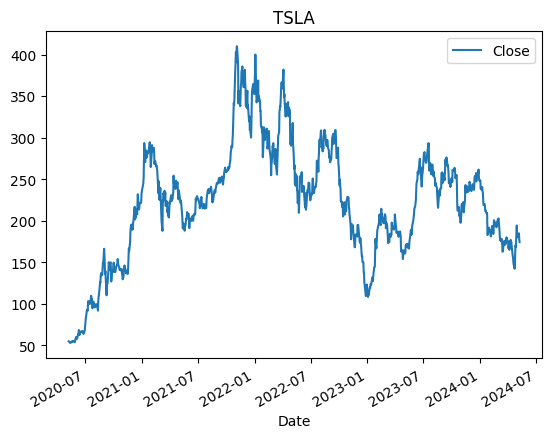

In [ ]:
# Retrieving all of the stock's data from yahoo finance
stock = yf.Ticker(ticker)
stock_hist = stock.history(period="48mo")

# Plotting a visualization of the stock's performance over time
stock_hist.plot.line(y="Close", use_index=True, title=ticker)

**Refining Data, and Calculating Target Values**

In [ ]:
# Refining the data to only the close price
data = stock_hist[["Close"]]
data = data.rename(columns = {'Close':'Actual_Close'})

# Getting the target values set up. This will identify if the price went up or down
data["Target"] = stock_hist.rolling(timeframe+1).apply(lambda x: x.iloc[timeframe] > x.iloc[0])["Close"]

# Making a copy of the stock's data, and shifting it forward
# in order to predict a buy for the current timeframe using the previous timeframe's data
stock_prev = stock_hist.copy()
stock_prev = stock_prev.shift(timeframe)

# Joining the previous timeframe's data with the current timeframe and target values for a better visualization
# and a more cohesive unit of data
predictors = ["Close", "Volume", "Open", "High", "Low"]
data = data.join(stock_prev[predictors]).iloc[timeframe:]

**Random Forest Classifier**

In [ ]:
# Defining the random forest classifier model
RFC = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)

def backtest(data, RFC, predictors, start=100, step=25):
    predictions = []
    # Loop over the dataset in increments
    for i in range(start, data.shape[0], step):
        # Split into train and test sets
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()

        # Fit the random forest model
        RFC.fit(train[predictors], train["Target"])

        # Make predictions
        preds = RFC.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)

        predsClass = preds.copy()
        predsClass[preds > .6] = 1
        predsClass[preds <= .6] = 0

        # Combine predictions and test values
        combined = pd.concat({"Target": test["Target"],"Predictions": predsClass, "Percentages": preds}, axis=1)

        predictions.append(combined)


    return pd.concat(predictions)

**Adding Accuracy Through Rolling Means and Ratios** - not in use currently

In [ ]:
weekly_mean = data.rolling(7).mean()["Close"]
monthly_mean = data.rolling(30).mean()["Close"]
quarterly_mean = data.rolling(90).mean()["Close"]
annual_mean = data.rolling(365).mean()["Close"]

weekly_trend = data.shift(1).rolling(7).sum()["Target"]

data["weekly_mean"] = weekly_mean / data["Close"]
data["quarterly_mean"] = quarterly_mean / data["Close"]
data["annual_mean"] = annual_mean / data["Close"]

data["annual_weekly_mean"] = data["annual_mean"] / data["weekly_mean"]
data["annual_quarterly_mean"] = data["annual_mean"] / data["quarterly_mean"]
data["weekly_trend"] = weekly_trend

data["open_close_ratio"] = data["Open"] / data["Close"]
data["high_close_ratio"] = data["High"] / data["Close"]
data["low_close_ratio"] = data["Low"] / data["Close"]

full_predictors = predictors + ["weekly_mean", "quarterly_mean", "annual_mean", "annual_weekly_mean", "annual_quarterly_mean", "open_close_ratio", "high_close_ratio", "low_close_ratio", "weekly_trend"]

**Backtest Function Call**

In [ ]:
predictions = backtest(data.iloc[365:], RFC, full_predictors)

precision_score(predictions["Target"], predictions["Predictions"])

0.6875

**CHECKING CURRENT DAY**

In [ ]:
predictions[["Predictions","Percentages"]].tail(1)

,Predictions,Percentages
Date,,
2024-05-08 00:00:00-04:00,1.0,0.621272


**Trades made in the last 100 days**

<Axes: xlabel='Date'>

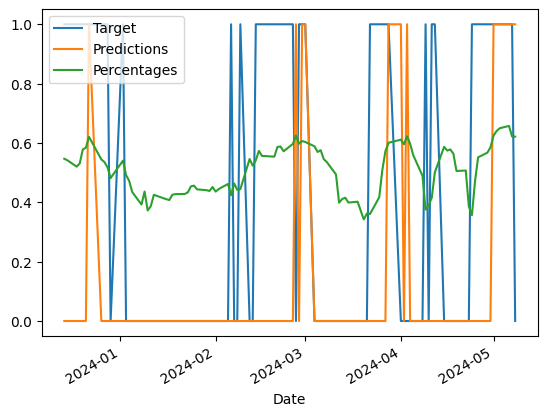

In [ ]:
predictions.iloc[-100:].plot()

#**More Data**

In [ ]:
df = data
# Drop the 'Target' column
df.drop(columns=['Target'], inplace=True)

# Create a new DataFrame with required columns
new_df = df[['Actual_Close', 'Volume', 'High', 'Low']].copy()

# Add Close and Open data from the last 10 days
for i in range(1, 11):
    new_df[f'Close_{i}'] = df['Close'].shift(i)
    new_df[f'Open_{i}'] = df['Open'].shift(i)

# Drop rows with NaN values resulting from shifting
new_df.dropna(inplace=True)

print(new_df)

                           Actual_Close       Volume        High         Low  \
Date                                                                           
2020-06-03 00:00:00-04:00     58.863998  149812500.0   55.452000   54.133331   
2020-06-04 00:00:00-04:00     57.625332  121345500.0   55.639999   54.380669   
2020-06-05 00:00:00-04:00     59.043999  173242500.0   55.180668   52.333332   
2020-06-08 00:00:00-04:00     63.327999  108834000.0   54.983334   53.445999   
2020-06-09 00:00:00-04:00     62.711334  176467500.0   55.666668   53.613998   
...                                 ...          ...         ...         ...   
2024-05-02 00:00:00-04:00    180.009995  124545100.0  147.259995  141.110001   
2024-05-03 00:00:00-04:00    181.190002  181178000.0  167.970001  157.509995   
2024-05-06 00:00:00-04:00    184.759995  126427500.0  170.880005  158.360001   
2024-05-07 00:00:00-04:00    177.809998  109815700.0  172.119995  166.369995   
2024-05-08 00:00:00-04:00    174.134995 

In [ ]:
df = new_df

In [ ]:
df.reset_index(inplace=True)

# Extract year, month, and day into separate columns
df['Year'] = pd.to_datetime(df['Date']).dt.year
df['Month'] = pd.to_datetime(df['Date']).dt.month
df['Day'] = pd.to_datetime(df['Date']).dt.day

# Drop the original 'Date' column
df.drop(columns=['Date'], inplace=True)

# Set a new incrementing index
df.index = range(len(df))

df['Actual_Close'] = df['Actual_Close'].shift(1)
df['Volume'] = df['Volume'].shift(1)
df['High'] = df['High'].shift(1)
df['Low'] = df['Low'].shift(1)

df.drop(df.index[0], inplace=True)

In [ ]:
df.tail()

,Actual_Close,Volume,High,Low,Close_1,Open_1,Close_2,Open_2,Close_3,Open_3,...,Open_7,Close_8,Open_8,Close_9,Open_9,Close_10,Open_10,Year,Month,Day
985,179.990005,107097600.0,144.440002,138.800003,142.050003,140.559998,147.050003,148.970001,149.929993,151.250000,...,172.339996,174.600006,172.550003,171.759995,173.039993,176.880005,172.910004,2024,5,2
986,180.009995,124545100.0,147.259995,141.110001,144.679993,143.330002,142.050003,140.559998,147.050003,148.970001,...,170.240005,171.050003,172.339996,174.600006,172.550003,171.759995,173.039993,2024,5,3
987,181.190002,181178000.0,167.970001,157.509995,162.130005,162.839996,144.679993,143.330002,142.050003,140.559998,...,156.740005,161.479996,170.240005,171.050003,172.339996,174.600006,172.550003,2024,5,6
988,184.759995,126427500.0,170.880005,158.360001,170.179993,158.960007,162.130005,162.839996,144.679993,143.330002,...,157.639999,157.110001,156.740005,161.479996,170.240005,171.050003,172.339996,2024,5,7
989,177.809998,109815700.0,172.119995,166.369995,168.289993,168.850006,170.179993,158.960007,162.130005,162.839996,...,151.250000,155.449997,157.639999,157.110001,156.740005,161.479996,170.240005,2024,5,8


In [ ]:
result_df = pd.DataFrame()

# Add a column with 1 if the next day's Close_1 is greater than its Open_0, otherwise 0
result_df['Result'] = (df['Close_1'] > df['Open_1']).astype(int)
result_df = result_df.shift(-1, fill_value = 3)
result_df.drop(df.index[-1], inplace=True)
result_df.tail()

,Result
984,1
985,1
986,0
987,1
988,0


In [ ]:
df.drop(df.index[0], inplace=True)
num_rows, num_cols = df.shape

print(f"df has {num_rows} rows and {num_cols} columns.")

num_rows, num_cols = result_df.shape

print(f"result_df has {num_rows} rows and {num_cols} columns.")



df has 988 rows and 27 columns.
result_df has 988 rows and 1 columns.


In [ ]:
X = df.copy()
y = result_df.copy()

#**Models**

In [ ]:
scores = dict()  # set up a variable to store the final scores

####**Test Train Split**

In [ ]:
y = y.values.flatten()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y) # stratify ensures an equal ratio of each target

**Gradient Boosting**

In [ ]:
# Define Pipeline
estimators = [
    ('scaler', StandardScaler()),
    ('clf', HistGradientBoostingClassifier(max_iter=200, early_stopping=True, random_state=0))
]
pipe = Pipeline(estimators)

# Fit Pipeline to Training Data
pipe.fit(X_train, y_train)

# Display Information about the Fitted Model
print('n_estimators asked:', pipe[-1].max_iter)
print('n_estimators used:', pipe[-1].n_iter_)
print('Train Score:', pipe.score(X_train, y_train))
print('Test Score:', pipe.score(X_test, y_test))

# Store Scores in Dictionary (if desired)
scores['Hist GB Tree'] = pipe.score(X_test, y_test)  # Store test score in 'scores'

# Example: Perform Grid Search for Hyperparameter Tuning
param_grid = {
    'clf__learning_rate': [0.01, 0.1, 0.5],
    'clf__max_depth': [3, 5, 7],
    'clf__min_samples_leaf': [1, 5, 10]
}
grid_search = GridSearchCV(pipe, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print('Best Parameters:', grid_search.best_params_)
print('Best Train Score:', grid_search.best_score_)

# Store Best Score from Grid Search (if desired)
scores['Hist GB Tree (Grid Search)'] = grid_search.best_score_

n_estimators asked: 200
n_estimators used: 79
Train Score: 0.9730094466936572
Test Score: 0.7530364372469636
Best Parameters: {'clf__learning_rate': 0.1, 'clf__max_depth': 7, 'clf__min_samples_leaf': 10}
Best Train Score: 0.6963903500816253


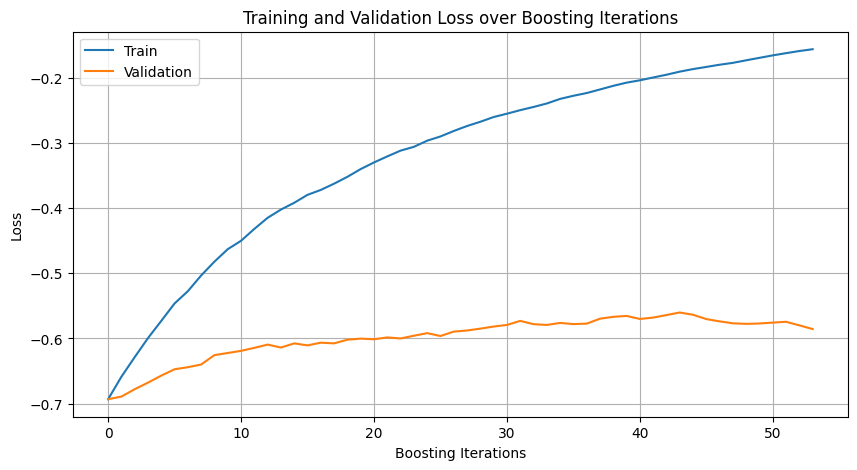

In [ ]:
# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(pipe.named_steps['clf'].train_score_, label='Train')
plt.plot(pipe.named_steps['clf'].validation_score_, label='Validation')
plt.xlabel('Boosting Iterations')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Boosting Iterations')
plt.legend()
plt.grid()
plt.show()

**Neural Network**

In [ ]:
from sklearn.neural_network import MLPClassifier

# Define Pipeline
estimators = [('scaler', StandardScaler()), ('clf', MLPClassifier(max_iter=2000, random_state=0))]
pipe = Pipeline(estimators)

# Grid Search Parameters
params = {'clf__hidden_layer_sizes': [(4,), (6,), (8,), (10,), (2, 2), (3, 3), (4, 4)]}  # Example parameter grid

print('Grid Parameters:', params)

grid_clf = GridSearchCV(pipe, param_grid=params, return_train_score=True)
grid_clf.fit(X_train, y_train)

print('Best parameters:', grid_clf.best_params_)
print(f"Best Train Score:\t{grid_clf.best_score_:0.3f}")


# Optionally, you can access the mean and standard deviation scores
mean_scores = grid_clf.cv_results_['mean_test_score']
std_scores = grid_clf.cv_results_['std_test_score']

Grid Parameters: {'clf__hidden_layer_sizes': [(4,), (6,), (8,), (10,), (2, 2), (3, 3), (4, 4)]}


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perce

Best parameters: {'clf__hidden_layer_sizes': (4, 4)}
Best Train Score:	0.930


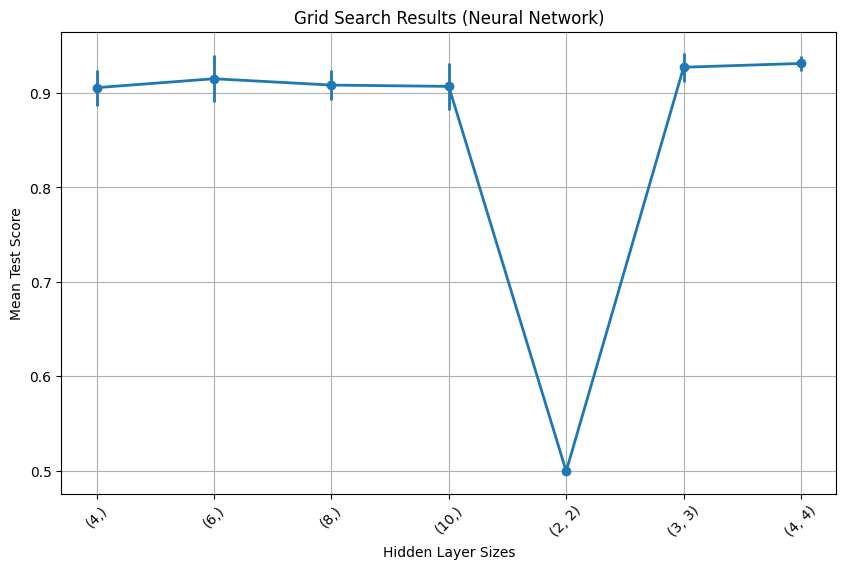

In [ ]:
def make_grid_plot(grid_search):
    import matplotlib.pyplot as plt

    # Extract relevant information from grid search results
    param_values = [str(p) for p in grid_search.cv_results_['param_clf__hidden_layer_sizes']]  # Use correct parameter key
    mean_scores = grid_search.cv_results_['mean_test_score']
    std_scores = grid_search.cv_results_['std_test_score']

    # Plot mean scores with error bars
    plt.figure(figsize=(10, 6))
    plt.errorbar(param_values, mean_scores, yerr=std_scores, fmt='o-', linewidth=2)
    plt.title("Grid Search Results (Neural Network)")
    plt.xlabel("Hidden Layer Sizes")
    plt.ylabel("Mean Test Score")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

# Call make_grid_plot with the grid_clf object
make_grid_plot(grid_clf)

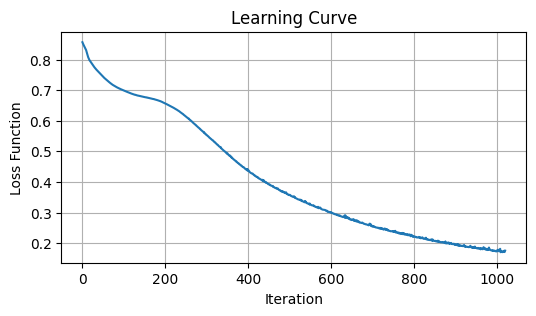

In [ ]:

plt.figure(figsize=(6,3))
clf = grid_clf.best_estimator_[-1]
plt.plot(clf.loss_curve_)
plt.ylabel('Loss Function')
plt.xlabel('Iteration')
plt.title('Learning Curve')
plt.grid()
plt.show()

In [ ]:
scores['NeuralNetwork'] = grid_clf.best_score_
print('Test Scores:')
for k,v in scores.items():
  print(f"{k}\t{v:0.3f}")

Test Scores:
Hist GB Tree	0.753
Hist GB Tree (Grid Search)	0.696
NeuralNetwork	0.930


In [ ]:

# Only run this one time after you are completely done
print(f"Grid Test SCORE:\t{grid_clf.score(X_test,y_test):0.3f}")

Grid Test SCORE:	0.935


**AdaBoost**

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score


# Define the pipeline steps
steps = [
    ('scaler', StandardScaler()),
    ('ada', AdaBoostClassifier(n_estimators=100, algorithm="SAMME", random_state=0))
]

# Create the pipeline
pipeline = Pipeline(steps)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Evaluate the pipeline on test data (single split)
accuracy_test = pipeline.score(X_test, y_test)
print("Accuracy on Test Data:", accuracy_test)

# Evaluate the pipeline using cross-validation
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
mean_cv_accuracy = np.mean(cv_scores)
print("Cross-Validation Mean Accuracy:", mean_cv_accuracy)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'ada__n_estimators': [50, 100, 200],
    'ada__learning_rate': [0.1, 0.5, 1.0]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Final evaluation with the best model found by GridSearchCV
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy_best_model = accuracy_score(y_test, y_pred)
print("Accuracy with Best Model on Test Data:", accuracy_best_model)

Accuracy on Test Data: 0.5707070707070707
Cross-Validation Mean Accuracy: 0.5316455696202532
Best Parameters: {'ada__learning_rate': 1.0, 'ada__n_estimators': 100}
Best Cross-Validation Accuracy: 0.5582536390521181
Accuracy with Best Model on Test Data: 0.5707070707070707


**Bagging**

In [ ]:

from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [ ]:

# Define a list of candidate estimators to evaluate
estimators = [
    ('RandomForest', RandomForestClassifier()),
    ('SVM', SVC()),
    ('MLP', MLPClassifier()),
    ('KNN', KNeighborsClassifier()),
    ('LogisticRegression', LogisticRegression())
]

# Evaluate each estimator using cross-validation and select the best one
best_estimator = None
best_score = 0

for name, estimator in estimators:
    # Create a pipeline with preprocessing (if needed) and the current estimator
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        (name, estimator)
    ])

    # Perform cross-validation and calculate mean accuracy
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5)
    mean_accuracy = cv_scores.mean()

    # Update best estimator if current estimator performs better
    if mean_accuracy > best_score:
        best_estimator = estimator
        best_score = mean_accuracy

# Train the best estimator on the full training data
best_estimator.fit(X_train, y_train)

# Evaluate the best estimator on the test set
y_pred = best_estimator.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Best Estimator: {best_estimator.__class__.__name__}")
print(f"Cross-Validation Mean Accuracy: {best_score:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

Best Estimator: LogisticRegression
Cross-Validation Mean Accuracy: 0.8380
Test Accuracy: 0.5303


In [ ]:
# Define the steps in the pipeline
steps = [
    ('scaler', StandardScaler()),
    ('bagging', BaggingClassifier(base_estimator=LogisticRegression(max_iter=1000),
                                   max_samples=0.5,
                                   max_features=0.5,
                                   random_state=42))
]

# Create the pipeline
pipeline = Pipeline(steps)

# Fit the pipeline on training data
pipeline.fit(X_train, y_train)

# Evaluate the pipeline on test data
accuracy = pipeline.score(X_test, y_test)
print("Accuracy on Test Data:", accuracy)

# Evaluate the pipeline using cross-validation
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
mean_cv_accuracy = cv_scores.mean()
print("Cross-Validation Mean Accuracy:", mean_cv_accuracy)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'bagging__n_estimators': [50, 100, 200],  # Number of base estimators
    'bagging__base_estimator__C': [0.01, 0.1, 1.0, 10.0],  # Regularization parameter for LogisticRegression
    'bagging__max_samples': [0.5, 0.7, 1.0],  # Fraction of samples to use for each base estimator
    'bagging__max_features': [0.5, 0.7, 1.0]  # Fraction of features to use for each base estimator
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Final evaluation with the best model found by GridSearchCV
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy_best_model = accuracy_score(y_test, y_pred)
print("Accuracy with Best Model on Test Data:", accuracy_best_model)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy on Test Data: 0.8131313131313131


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Cross-Validation Mean Accuracy: 0.740506329113924


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/en

Best Parameters: {'bagging__base_estimator__C': 10.0, 'bagging__max_features': 1.0, 'bagging__max_samples': 1.0, 'bagging__n_estimators': 50}
Best Cross-Validation Accuracy: 0.9253322195337406
Accuracy with Best Model on Test Data: 0.9444444444444444


**Support Vector Machine**

Grid Parameters: {'clf__kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
Best parameters: {'clf__kernel': 'linear'}
Best Train Score:	0.844


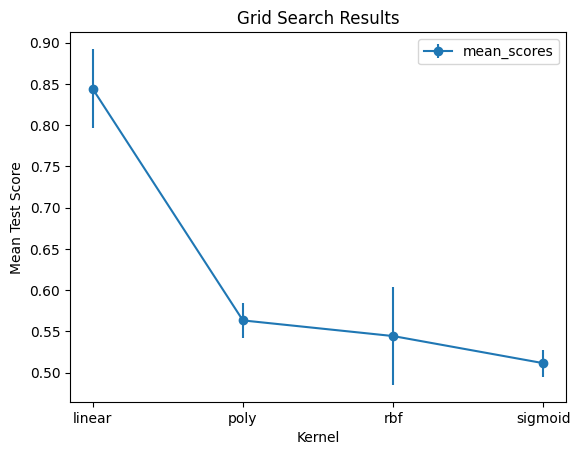

Test Score (Best Model): 0.884


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

def make_grid_plot(grid_search):
    # Extract grid search results
    params = grid_search.param_grid
    mean_scores = grid_search.cv_results_['mean_test_score']
    std_scores = grid_search.cv_results_['std_test_score']
    param_values = params['clf__kernel']  # Extract kernel values from parameter grid

    # Plot mean scores
    plt.errorbar(param_values, mean_scores, yerr=std_scores, fmt='o-', label='mean_scores')
    plt.title('Grid Search Results')
    plt.xlabel('Kernel')
    plt.ylabel('Mean Test Score')
    plt.legend()
    plt.show()

# Define Pipeline
estimators = [('scaler', StandardScaler()), ('clf', SVC())]
pipe = Pipeline(estimators)

# Grid Search Parameters
params = {'clf__kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
print('Grid Parameters:', params)

grid_clf = GridSearchCV(pipe, param_grid=params, return_train_score=True)
grid_clf.fit(X_train, y_train)

print('Best parameters:', grid_clf.best_params_)
print(f"Best Train Score:\t{grid_clf.best_score_:0.3f}")

# Plot grid search results
make_grid_plot(grid_clf)

# Evaluate the best model on test data
best_model = grid_clf.best_estimator_
test_score = best_model.score(X_test, y_test)
print(f"Test Score (Best Model): {test_score:0.3f}")

**Voting**

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
clf1 = HistGradientBoostingClassifier(learning_rate=0.5, max_depth=7, min_samples_leaf=5)
clf2 = MLPClassifier(hidden_layer_sizes=(3, 3))
clf3 = AdaBoostClassifier(n_estimators=100, algorithm="SAMME", random_state=0, learning_rate=1.0)
clf4 = BaggingClassifier(base_estimator=LogisticRegression(),max_samples=1.0, max_features=1.0,n_estimators=50)
clf5 = SVC(kernel='linear', decision_function_shape='ovr')

# Create a VotingClassifier
voting_clf = VotingClassifier(
    estimators=[
        #('gb', clf1),
        #('mlp', clf2),
        #('adaboost', clf3),
        ('bagging', clf4),
        ('svm', clf5)
    ],
    voting='hard'  # Use 'hard' voting for majority rule
)

# Fit the VotingClassifier on the training data
voting_clf.fit(X_train, y_train)

# Evaluate the VotingClassifier on the test data
y_pred = voting_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Voting Classifier Accuracy:", accuracy)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
